## Imports

In [247]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import timedelta
from tqdm import tqdm 
import time
import random
import os


In [248]:
seed = 19

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Hyper-parameters

In [249]:
batch_size = 32
lr = 1e-3         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 10

## Data Loading

In [250]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.data = dataset.drop(["gt"], axis=1)
        self.targets = dataset["gt"]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        data = torch.from_numpy(np.array(row)).float().reshape(1, -1)
        target = self.targets.iloc[idx]
        # normalization 
        # data = (data - data.mean()) / (data.std() if data.std() else 1)        
        # data = (data - data.min()) / (data.max() - data.min() if (data.max()-data.min()) else 1) * 10
        # data = data - data.mean() + data.max() - data.min()
        data = data - data.mean()
        return data, target

In [251]:
full_dataset = pd.read_csv('../dataset/synth_ts_data/train_hum.csv', index_col=False)
train_size = int(0.8 * len(full_dataset))

train_dataset_df = full_dataset[:train_size]
train_dataset = Dataset(train_dataset_df)
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
        )

val_dataset_df = full_dataset[train_size+1:]
val_dataset = Dataset(val_dataset_df)
val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=1,
        )

test_dataset_df = pd.read_csv('../dataset/synth_ts_data/test_hum.csv', index_col=False)
test_dataset = Dataset(test_dataset_df)
test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=1,
        )

In [252]:
print(f"> train size: {len(train_loader)*batch_size}") 
print(f"> val size: {len(val_loader)}")
print(f"> test size: {len(test_loader)}")

> train size: 16192
> val size: 4045
> test size: 5055


## AE Model Definition

In [253]:
class EncoderBlock(nn.Module):
    def __init__(self, enc_conv_layer, enc_pool_layer=None, enc_norm_layer=None, enc_act_func=None):
        super(EncoderBlock, self).__init__()
        self.encoding_block = nn.Sequential()
        self.encoding_block.add_module('conv', enc_conv_layer)
        if enc_pool_layer!=None: self.encoding_block.add_module('pool', enc_pool_layer)
        if enc_norm_layer!= None: self.encoding_block.add_module('norm', enc_norm_layer)
        if enc_act_func!= None: self.encoding_block.add_module('act', enc_act_func)

    def forward(self, x):
        return self.encoding_block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, dec_tconv_layer, dec_norm_layer=None, dec_act_func=None):
        super(DecoderBlock, self).__init__()
        self.decoding_block = nn.Sequential()
        self.decoding_block.add_module('tconv', dec_tconv_layer)
        if dec_norm_layer!=None: self.decoding_block.add_module('norm', dec_norm_layer)
        if dec_act_func!= None: self.decoding_block.add_module('act', dec_act_func)
        
    def forward(self, x):
        return self.decoding_block(x)
    

conv_n_out_channels = [1, 2, 4, 8, 16, 32]
conv_kernel_size = [3, 5, 7, 10, 15]
pool_type = ['none', 'max', 'avg']
pool_kernel_size = [3, 5, 7]
norm_type = ['none', 'batch', 'instance']
act_funcs = ['none', 'sigmoid', 'tanh', 'relu', 'elu']

n_blocks = 2
len_block = 6

def translate_sequence(sequence):
    # assert len(sequence)==len_block*n_blocks
    i = 0
    dec_seq = []
    while i<len(sequence):
        block = sequence[i: i+len_block]
        i += len_block
        dec_block = {
            "conv_n_out_channels,": conv_n_out_channels[block[0]],
            "conv_kernel_size,": conv_kernel_size[block[1]],
            "pool_type,": pool_type[block[2]],
            "pool_kernel_size": pool_kernel_size[block[3]],
            "norm_type,": norm_type[block[4]],
            "act_funcs,": act_funcs[block[5]]
        }
        dec_seq.append(dec_block)
    return dec_seq


class AE(nn.Module):

    def __init__(self, sequence):
        super(AE, self).__init__()
        encoder_blocks_list, decoder_blocks_list = self.build_model(sequence)
        self.encoder = nn.ModuleList(encoder_blocks_list)
        self.decoder = nn.ModuleList(decoder_blocks_list)


    def build_model(self, sequence):
        # builds model architecture from token sequence
        encoder_blocks_list = []
        decoder_blocks_list = []
        tr_seq = translate_sequence(sequence)
        conv_n_in_channels = 1
        prev_enc_out_width = 100

        for i, block in enumerate(tr_seq):
            conv_n_out_channels, conv_kernel_size, pool_type, pool_kernel_size, norm_type, act_func = block.values()
            print(block.values())

            # Encoder
            # params
            conv_pad = 1
            conv_stride = 1
            pool_stride = 2
            conv_out_width = (prev_enc_out_width + 2*conv_pad - conv_kernel_size)//conv_stride + 1
            pool_out_width = (conv_out_width-pool_kernel_size)//pool_stride + 1 if pool_type in ['avg', 'max'] else conv_out_width
            
            # layers choices
            enc_conv_layer = nn.Conv1d(conv_n_in_channels, conv_n_out_channels, conv_kernel_size, conv_stride, conv_pad)

            if pool_type=='avg': enc_pool_layer = nn.AvgPool1d(pool_kernel_size, pool_stride)
            elif pool_type=='max': enc_pool_layer = nn.MaxPool1d(pool_kernel_size, pool_stride)
            else: enc_pool_layer = None

            if norm_type=='batch': enc_norm_layer = nn.BatchNorm1d(conv_n_out_channels)
            elif norm_type=='instance': enc_norm_layer = nn.InstanceNorm1d(conv_n_out_channels)
            else: enc_norm_layer=None

            if act_func=='relu': enc_act_func = nn.ReLU()
            elif act_func=='elu': enc_act_func = nn.ELU()
            elif act_func=='sigmoid': enc_act_func = nn.Sigmoid()
            elif act_func=='tanh': enc_act_func = nn.Tanh()
            else: enc_act_func = None

            encoder_blocks_list.append(
                EncoderBlock(
                    enc_conv_layer,
                    enc_pool_layer,
                    enc_norm_layer,
                    enc_act_func
                )
            )

            # Decoder
            # params
            convT_stride = 1
            convT_in_width = pool_out_width
            convT_out_width = prev_enc_out_width
            convT_kernel_size = int(convT_out_width-(convT_in_width-1)*convT_stride)

            dec_tconv_layer = nn.ConvTranspose1d(conv_n_out_channels, conv_n_in_channels, kernel_size=convT_kernel_size, stride=convT_stride)
            
            # layers choices
            if norm_type=='batch': dec_norm_layer = nn.BatchNorm1d(conv_n_in_channels)
            elif norm_type=='instance': dec_norm_layer = nn.InstanceNorm1d(conv_n_in_channels)
            else: dec_norm_layer=None

            if act_func=='relu': dec_act_func = nn.ReLU()
            elif act_func=='elu': dec_act_func = nn.ELU()
            elif act_func=='sigmoid': dec_act_func = nn.Sigmoid()
            elif act_func=='tanh': dec_act_func = nn.Tanh()
            else: dec_act_func = None

            decoder_blocks_list.insert(
                0,
                DecoderBlock(
                    dec_tconv_layer,
                    dec_norm_layer,
                    dec_act_func
                )
            )

            conv_n_in_channels = conv_n_out_channels
            prev_enc_out_width = pool_out_width

        return encoder_blocks_list, decoder_blocks_list


    def forward(self, x):
        # print(self.encoder)
        # print(self.decoder)
        encode = x
        # print('inp',encode.shape)
        for encoder_block in self.encoder:
            encode = encoder_block(encode)
        #     print('enc',encode.shape)
        # print(' z ',encode.shape)
        decode = encode
        for decoder_block in self.decoder:
            decode = decoder_block(decode)
            # print('dec',decode.shape)
        return decode

## Training

In [254]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using:', device)
model = AE([2,3,0,2,2,0, 3,0,2,2,1,1, 4,0,0,0,1,2])
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)
model

using: cuda
dict_values([4, 10, 'none', 7, 'instance', 'none'])
dict_values([8, 3, 'avg', 7, 'batch', 'sigmoid'])
dict_values([16, 3, 'none', 3, 'batch', 'tanh'])


AE(
  (encoder): ModuleList(
    (0): EncoderBlock(
      (encoding_block): Sequential(
        (conv): Conv1d(1, 4, kernel_size=(10,), stride=(1,), padding=(1,))
        (norm): InstanceNorm1d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (1): EncoderBlock(
      (encoding_block): Sequential(
        (conv): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (pool): AvgPool1d(kernel_size=(7,), stride=(2,), padding=(0,))
        (norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Sigmoid()
      )
    )
    (2): EncoderBlock(
      (encoding_block): Sequential(
        (conv): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Tanh()
      )
    )
  )
  (decoder): ModuleList(
    (0): DecoderBlock(
      (decoding_block): Sequential(
        (tconv): ConvTranspose1

In [255]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for i, (data, _) in tqdm(enumerate(train_loader), disable=True):
        original_ts = data.to(device)
        reconstructed_ts = model(original_ts)
        loss = criterion(original_ts, reconstructed_ts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_loader)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 1/10
[LOSS] 0.9719539284706116
Epoch Complete in 0:00:05.036824
-----------------------------------------------
[EPOCH] 2/10
[LOSS] 0.9259258046922948
Epoch Complete in 0:00:05.024660
-----------------------------------------------
[EPOCH] 3/10
[LOSS] 0.9197245251991061
Epoch Complete in 0:00:04.995142
-----------------------------------------------
[EPOCH] 4/10
[LOSS] 0.9162973702660663
Epoch Complete in 0:00:04.868358
-----------------------------------------------
[EPOCH] 5/10
[LOSS] 0.9138389129648096
Epoch Complete in 0:00:05.010443
-----------------------------------------------
[EPOCH] 6/10
[LOSS] 0.9118473869067407
Epoch Complete in 0:00:04.917346
-----------------------------------------------
[EPOCH] 7/10
[LOSS] 0.910111419061427
Epoch Complete in 0:00:05.343085
-----------------------------------------------
[EPOCH] 8/10
[LOSS] 0.9085046747927609
Epoch Complete in 0:00:04.969172
-----------------------------------------

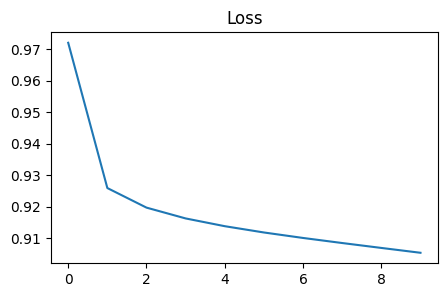

In [256]:
_, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

## Choosing threshold using Valid data

In [257]:
model.eval()
losses = []
for i, (data, _) in tqdm(enumerate(val_loader)):
    original_ts = data.to(device)
    reconstructed_ts = model(original_ts)
    loss = criterion(original_ts, reconstructed_ts)
    losses.append(loss.item())

4045it [00:06, 587.55it/s]


In [258]:
loss_threshold = np.percentile(losses, q=99)
print(loss_threshold)

1.0388856363296508


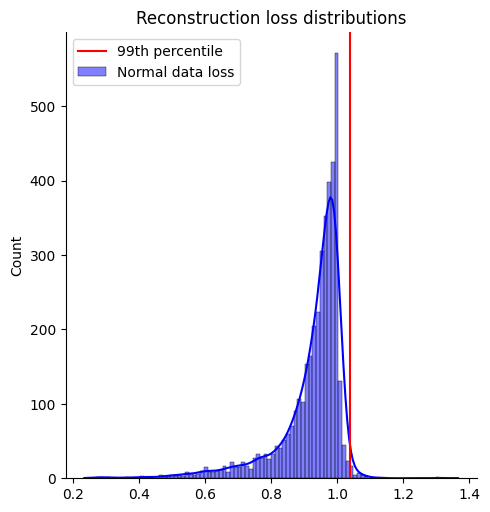

In [259]:
sns.displot(losses, bins=100, kde=True, color='blue', label="Normal data loss")
plt.axvline(loss_threshold, 0.0, 10, color='r', label="99th percentile")
plt.title("Reconstruction loss distributions")
plt.legend()
plt.show()

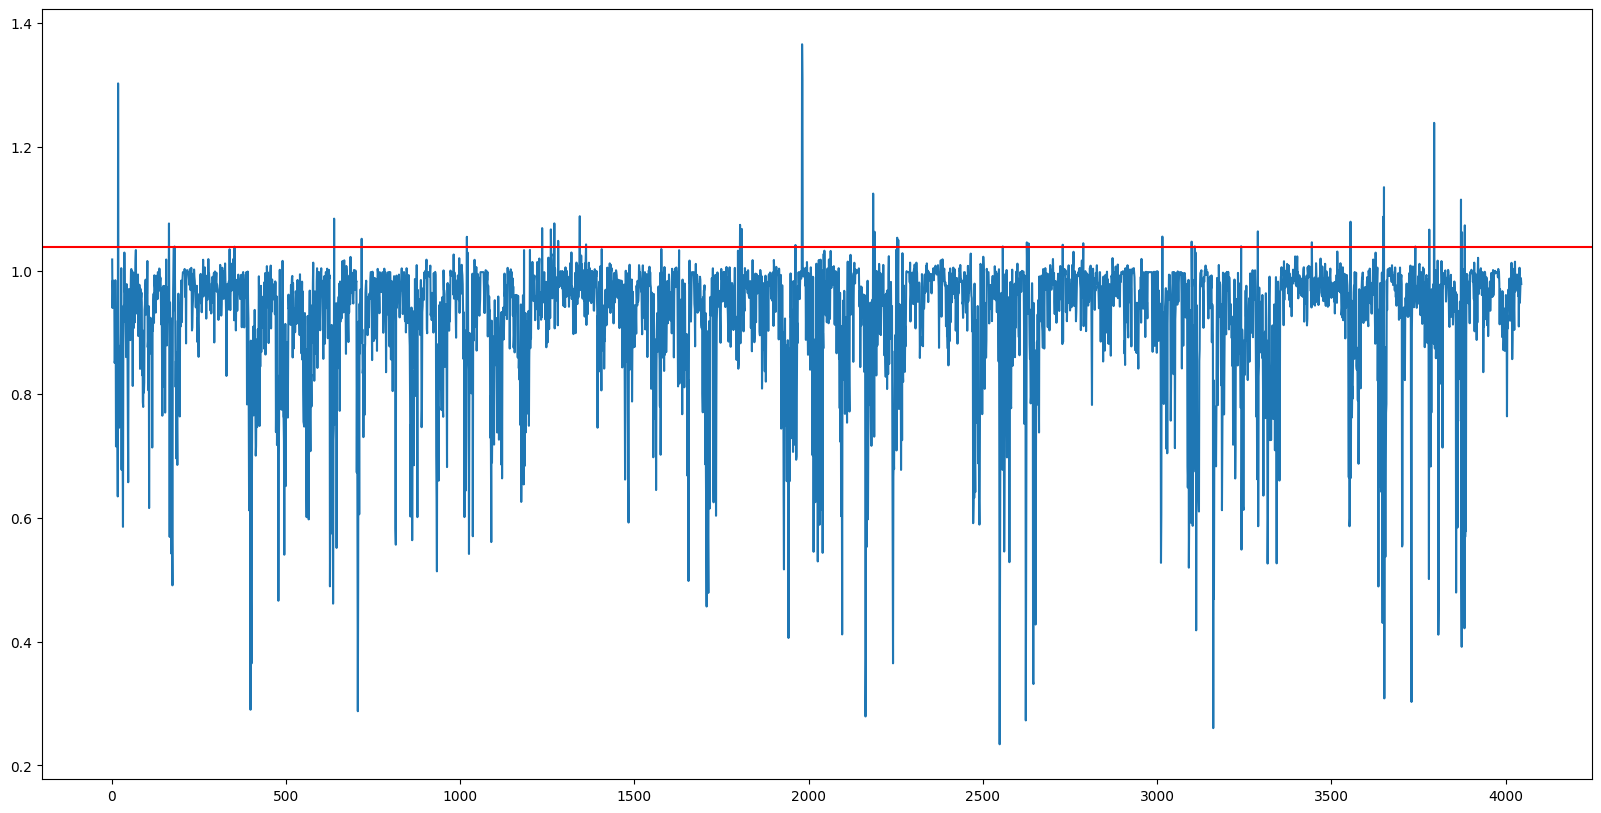

In [260]:
plt.figure(figsize=(20,10))
plt.plot(range(1, len(losses)+1), losses)
plt.axhline(loss_threshold, 0.0, 10, color='r')

## Anomaly detection on contaminated test data

5055it [00:09, 542.96it/s]


[TP] 939	[FP] 77
[FN] 57	[TN] 3982
F1 score = 0.9333996023856859


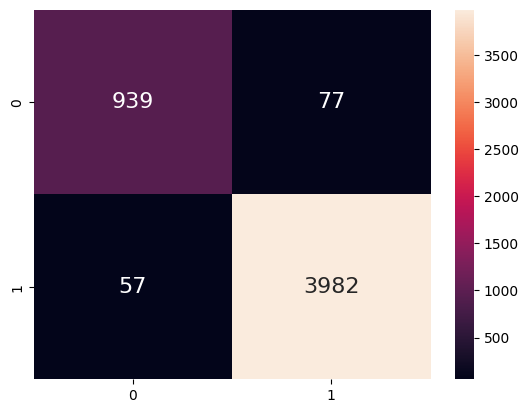

In [261]:
tp = 0
fp = 0
tn = 0
fn = 0

model.eval()
for i, (data, gt) in tqdm(enumerate(test_loader)):
    original_ts = data.to(device)
    reconstructed_ts = model(original_ts)
    loss = criterion(original_ts, reconstructed_ts)
    if loss >= loss_threshold:
        if gt == 1:
            tp += 1
        else:
            fp += 1
    else:
        if gt == 1:
            fn += 1
        else:
            tn += 1

print('[TP] {}\t[FP] {}'.format(tp, fp))
print('[FN] {}\t[TN] {}'.format(fn, tn))

precision = tp/(tp+fp if tp+fp else 1)
recall = tp/(tp+fn if tp+fp else 1)
f1 = 2*precision*recall/(precision+recall if precision+recall else 1)
print(f"F1 score = {f1}")

conf = [[tp,fp],[fn,tn]]
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')
plt.show()

Example of normal sample reconstruction

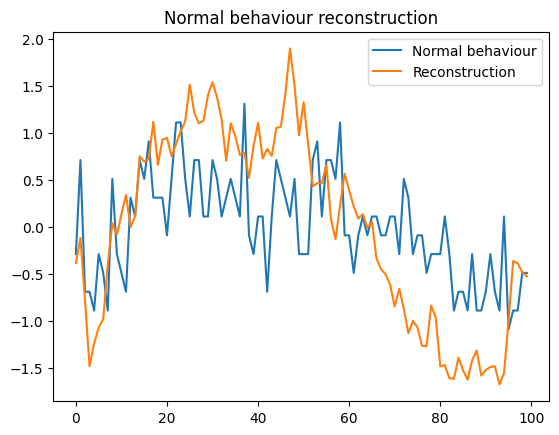

reconstruction loss = 0.6350623965263367
threshold = 1.0388856363296508


In [262]:
for i, (data, gt) in tqdm(enumerate(test_loader), disable=True):
    if gt==0:
        if i>1902:
            original_ts = data.to(device)
            reconstructed_ts = model(original_ts)
            loss = criterion(original_ts, reconstructed_ts)
            if loss>=loss_threshold: continue
            plt.plot(original_ts[0].cpu().detach().numpy()[0], label="Normal behaviour")
            plt.plot(reconstructed_ts[0].cpu().detach().numpy()[0], label="Reconstruction")
            plt.legend()
            plt.title("Normal behaviour reconstruction")
            plt.show()
            print(f"reconstruction loss = {criterion(original_ts, reconstructed_ts)}\nthreshold = {loss_threshold}")
            break

Example of a detected anomaly 

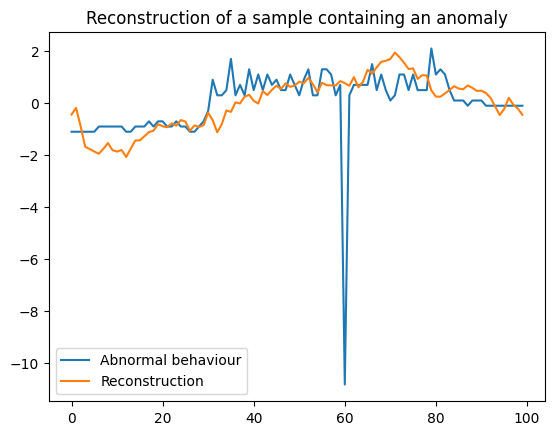

reconstruction loss = 1.7807282209396362
threshold = 1.0388856363296508


In [263]:
for i, (data, gt) in tqdm(enumerate(test_loader), disable=True):
    if gt==1:
        if i>2830:
            original_ts = data.to(device)
            reconstructed_ts = model(original_ts)
            loss = criterion(original_ts, reconstructed_ts)
            if loss<=loss_threshold: continue
            plt.plot(original_ts[0].cpu().detach().numpy()[0], label="Abnormal behaviour")
            plt.plot(reconstructed_ts[0].cpu().detach().numpy()[0], label="Reconstruction")
            plt.legend()
            plt.title("Reconstruction of a sample containing an anomaly")
            plt.show()
            print(f"reconstruction loss = {criterion(original_ts, reconstructed_ts)}\nthreshold = {loss_threshold}")
            break
            # plt.savefig(f"figs/{i}.jpg")
            # plt.clf()

Loss distribution

In [264]:
norm_losses = []
anom_losses = []

for i, (data, gt) in tqdm(enumerate(test_loader), disable=True):
    original_ts = data.to(device)
    reconstructed_ts = model(original_ts)
    loss = criterion(original_ts, reconstructed_ts)
    if gt==0:
        norm_losses.append(loss.cpu().detach().item())
    if gt==1:
        anom_losses.append(loss.cpu().detach().item())

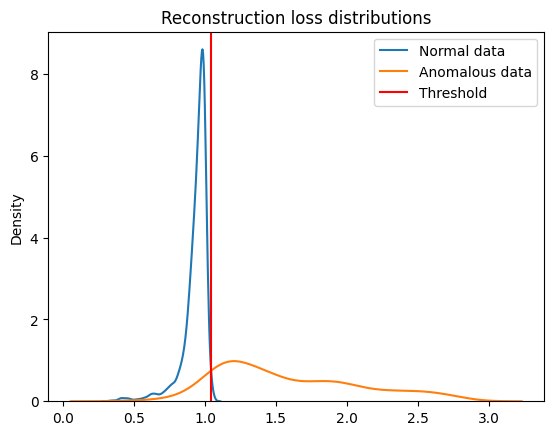

In [265]:
sns.kdeplot(sorted(norm_losses)[:-50], label='Normal data') # dont display values too far from threshold
sns.kdeplot(sorted(anom_losses)[:-350], label='Anomalous data') 
plt.axvline(loss_threshold, 0.0, 10, color='r', label='Threshold')
plt.title("Reconstruction loss distributions")
plt.legend()
plt.show()